# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#1D-PDFs"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1D PDFs</a></div><div class="lev3"><a href="#PDF-of-scaling-in-percentile-bins-of-pr"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>PDF of scaling in percentile bins of pr</a></div><div class="lev3"><a href="#2D-PDFs"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>2D PDFs</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-qvstar-and-omega"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Decompose variance into its contributions from qvstar and omega</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [89]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [3]:
%%time
print("-- load environment and variables")
print()

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'

all_varnames = 'omega','pr','ts','ta','relhum','ps','pres'

ref_time_stride = '1h'
ref_resolution = '1dx'

print("- load data for the following options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
daskarray = False
tracktime = True
# dates = ('185005010100','185005020000')
dates = ('185005010100','185105010000')
handle = 'h0'
plotAll2dPDFs = True
bootstrap = True

-- load environment and variables

- load data for the following options:
CPU times: user 673 µs, sys: 721 µs, total: 1.39 ms
Wall time: 712 µs


In [4]:
if tracktime:
    t0 = time.time()
    t_loops = []

In [39]:
for v in ['compset','experiment','member','subset','ref_time_stride','ref_resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

print()
omega_init,pr_init,ts_init,ta_init,relhum_init,ps_init = \
    getValues([omega_id,pr_id,ts_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,ref_time_stride,ref_resolution,
              daskarray=daskarray,dates=dates,handle=handle)
pr_init *= rho_l    # convert from m/s to kg/m2/s

print()
print("get inputpaths")

historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres_init = computeP(ps_init)

cn = getArrayType(pres_init)

compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
ref_time_stride: 1h
ref_resolution: 1dx
daskarray: False
dates: ('185005010100', '185105010000')

Importing OMEGA, PRECT, TS, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000

get inputpaths
compute pressure levels


In [40]:
if tracktime:
    t1 = time.time()
    t_loops.append(t1)
    print()
    print("! time spent to load the data:",time2str(t1-t0))



! time spent to load the data: 02:54:28


In [41]:
#---- single scale ----#
# start comment
time_stride = '1h'
resolution = '3dx'
# stop comment

#---- multiple scales ----#
# # start uncomment
# time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
# resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'
# for time_stride in time_strides:
#     for resolution in resolutions:
# # stop uncomment

#++# start indentation for multiple scales

print()
print("-----------------------------------------------------------------")
print("!          Start analysis for time_stride {:4}                  !".format(time_stride))
print("!                          and resolution {:4}                  !".format(resolution))
print("-----------------------------------------------------------------")
print()


-----------------------------------------------------------------
!          Start analysis for time_stride 1h                    !
!                          and resolution 3dx                   !
-----------------------------------------------------------------



In [43]:
print("convert data to target resolutions")

tc0 = time.time()

for varname in all_varnames:
    
    tc1 = time.time()
    setattr(thismodule,varname,
            coarsenTimeStride(coarsenResolution(getattr(thismodule,"%s_init"%varname),
                                                resolution),
                              time_stride))
    print("- %s:"%varname,time.time()-tc1,'s')
print("- all variables:",time.time()-tc0,'s')

qvstar = saturationSpecificHumidity(pres=pres,temp=ta)

convert data to target resolutions
- omega: 0.03440690040588379 s
- pr: 0.0014979839324951172 s
- ts: 0.0013859272003173828 s
- ta: 0.03431582450866699 s
- relhum: 0.030927181243896484 s
- ps: 0.0010271072387695312 s
- pres: 0.017621994018554688 s
- all variables: 0.12421083450317383 s


In [9]:
print()
print("-- define output paths")
print()

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define output paths




# Derive scaling

In [10]:
print()
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()


-- compute (percentile-wise and pointwise) scaling approximation



In [11]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 13.6 ms, sys: 5.5 ms, total: 19.1 ms
Wall time: 18.3 ms


In [12]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
2553.0 11520


In [13]:
%%time
print("compute O'Gorman&Schneider scaling with environmental temperature profile")
eps_OGS09, pr_scOGS09_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta,pres,pr,
    ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09_vQ = adjustRanks(pr_scOGS09_vQ,targetranks,ranks_ref)
pr_scOGS09 = scalingOGS09(omega,ta,pres,efficiency=eps_OGS09,levdim=1)
print("eps_OGS09 =",eps_OGS09)

compute O'Gorman&Schneider scaling with environmental temperature profile
eps_OGS09 = 1.05358854943
CPU times: user 677 ms, sys: 83.7 ms, total: 760 ms
Wall time: 802 ms


In [14]:
%%time
print("compute O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
eps_OGS09ad, pr_scOGS09ad_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta_bottom,pres,pr,
    temp_type='adiabat',relhum=relhum,ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09ad_vQ = adjustRanks(pr_scOGS09ad_vQ,targetranks,ranks_ref)
pr_scOGS09ad = scalingOGS09(omega,ta_bottom,pres,temp_type='adiabat',relhum=relhum,efficiency=eps_OGS09ad,levdim=1)
print("eps_OGS09ad =",eps_OGS09ad)

compute O'Gorman&Schneider scaling with moist adiabat
eps_OGS09ad = 1.09914327972
CPU times: user 902 ms, sys: 85 ms, total: 987 ms
Wall time: 1.05 s


## Compute statistics

### 1D PDFs

In [16]:
print()
print("-- compute statistics")
print()


-- compute statistics



In [17]:
# %%time
print("mean of scalings in pr bins")
pr_scOGS09_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09ad_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09ad,pr,ranks_ref,rank_locations=rank_locations)

mean of scalings in pr bins


In [18]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_scOGS09_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09ad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09ad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges
CPU times: user 18.5 ms, sys: 1.43 ms, total: 19.9 ms
Wall time: 19.5 ms


### PDF of scaling in percentile bins of pr

In [19]:
print()
print("-- compute PDF of scalings in percentile bins of pr")
print()


-- compute PDF of scalings in percentile bins of pr



In [20]:
print("reference Q_slices")
iQ_slices = [slice(i_Q-k,i_Q+k) for k in range(1,6)]

reference Q_slices


In [22]:
varname_ref = 'pr'
var_ref = getattr(thismodule,varname_ref)

varnames = 'pr_scOGS09','pr_scOGS09ad'

for varname in varnames:
    
    print("- %s"%varname)

    var = getattr(thismodule,varname)

    for k in range(len(iQ_slices)):
        
        iQ_start = min(iQ_slices[k].start,ranks_ref.size-1)
        iQ_stop = min(iQ_slices[k].stop,ranks_ref.size-1)

        print("Q-slice %2.4f-%2.4f"%(ranks_ref[iQ_start],ranks_ref[iQ_stop]))

        sample_all = []
        for i in range(iQ_start,iQ_stop):
            stencil_Q = getStencilAtRank(ranks_ref[i],ranks_ref,bins,var_ref)
            if stencil_Q.sum() != 0:
                sample_all.append(var[stencil_Q])
        if len(sample_all) == 0:
            sample = np.array([])
        else:
            sample = np.hstack(sample_all)
        # perc,b = defineLinearBins(sample,20)
        ra,perc,b,den = compute1dDensities(sample[np.logical_not(np.isnan(sample))],n_lin_bins=20)
        # Save
        ra_varname = 'ranks_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)
        perc_varname = 'percentiles_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)
        b_varname = 'bins_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)
        den_varname = 'pdf1D_%s_%s_Q%dQ%d'%(varname,varname_ref,iQ_start,iQ_stop)
        setattr(thismodule,ra_varname,ra)
        setattr(thismodule,perc_varname,perc)
        setattr(thismodule,b_varname,b)
        setattr(thismodule,den_varname,den)


- pr_scOGS09
Q-slice 99.8741-99.9206
Q-slice 99.8415-99.9369
Q-slice 99.8005-99.9499
Q-slice 99.7488-99.9602
Q-slice 99.6838-99.9684
- pr_scOGS09ad
Q-slice 99.8741-99.9206
Q-slice 99.8415-99.9369
Q-slice 99.8005-99.9499
Q-slice 99.7488-99.9602
Q-slice 99.6838-99.9684


### 2D PDFs

In [31]:
print()
print("-- compute 2D PDF of scalings and pr")
print()


-- compute 2D PDF of scalings and pr



In [33]:
# %%time
print("compute 2D PDFs")

all_pr_varnames = set({'pr','pr_scOGS09','pr_scOGS09ad'})

for varname1 in all_pr_varnames:
    for varname2 in all_pr_varnames.difference(varname1):

        var1 = getattr(thismodule,varname1)
        var2 = getattr(thismodule,varname2)
        
        ranks1, percentiles1, bins1, ranks2, percentiles2, bins2, density2D = \
            compute2dStatsILOnRefRanks(var1,var2,ranks_ref)
            
        setattr(thismodule,"density2D_%s_%s"%(varname1,varname2),density2D)

        N1 = sampleSizeAtAllRanks(ranks1,var1,ranks_ref,bins=bins1)
        N2 = sampleSizeAtAllRanks(ranks2,var2,ranks_ref,bins=bins2)
        norm_factor = normalize2dDensity(N1,N2,n_pts)

        norm_density2D = density2D/norm_factor
        setattr(thismodule,"norm_density2D_%s_%s"%(varname1,varname2),norm_density2D)
        setattr(thismodule,"N_%s"%(varname1),N1)
        setattr(thismodule,"N_%s"%(varname2),N2)

compute 2D PDFs


### Decompose variance into its contributions from qvstar and omega

In [34]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()


-- decompose variance into qvstar and omega contributions



In [29]:
%%time 
print("Compute the variance in pr")
scaling_names = 'scOGS09','scOGS09ad'

Ntimes = 100 if bootstrap else 1
fsub = 0.5 if bootstrap else 1

for sc_name in scaling_names:

    # compute variance from full sample
    pr_values = getattr(thismodule,'pr_%s'%sc_name)
    var_pr = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations)
    setattr(thismodule,'var_pr_%s_prQ'%sc_name,var_pr)
    
    # bootstrapping
    all_var_pr = np.empty((Ntimes,var_pr.size))
    for i in range(Ntimes):
        all_var_pr[i,:] = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations,random_fraction=fsub)
    if bootstrap:
        setattr(thismodule,'var_pr_%s_I25_prQ'%sc_name,all_var_pr[0])
        setattr(thismodule,'var_pr_%s_I75_prQ'%sc_name,all_var_pr[1])

Compute the variance in pr
CPU times: user 1.21 s, sys: 10.1 ms, total: 1.22 s
Wall time: 1.26 s


In [30]:
print("normalized variability")
for sc_name in scaling_names:
    norm_var_pr = getattr(thismodule,'var_pr_%s_prQ'%sc_name)/getattr(thismodule,'pr_%s_prQ'%sc_name)**2
    setattr(thismodule,'norm_var_pr_%s_prQ'%sc_name,norm_var_pr)
    if bootstrap:
        for int_bnd in 'I25','I75':
            norm_var_pr_Ibnd = getattr(thismodule,'var_pr_%s_%s_prQ'%(sc_name,int_bnd))/\
                getattr(thismodule,'pr_%s_prQ'%sc_name)**2
            setattr(thismodule,'norm_var_pr_%s_%s_prQ'%(sc_name,int_bnd),norm_var_pr_Ibnd)
            # for printing only:
            setattr(thismodule,'norm_var_pr_%s'%int_bnd,norm_var_pr_Ibnd)
    
    print("scaling %s : %1.5f"%(sc_name,np.nanmean(norm_var_pr[iQ_slice])),end='')
    if bootstrap:
        print("\t (%1.5f,%1.5f)"%(np.nanmean(norm_var_pr_I25[iQ_slice]),
                                  np.nanmean(norm_var_pr_I75[iQ_slice])))
    else:
        print()

normalized variability
scaling scOGS09 : 0.01028	 (0.00875,0.00617)
scaling scOGS09ad : 0.01949	 (0.00632,0.01455)


(24, 29, 10, 48)


In [114]:
%%time
print("compute variability terms")

X = np.apply_along_axis(arr=omega,axis=1,func1d=(lambda x:np.convolve(x,(0.5,0.5),mode='valid')))
Y = np.diff(qvstar,axis=1)

var_X_prQ = trCovXYAtAllZRanks(targetranks,X,X,pr,ranks_ref,rank_locations=rank_locations)
var_Y_prQ = trCovXYAtAllZRanks(targetranks,Y,Y,pr,ranks_ref,rank_locations=rank_locations)

X_dot_Y = np.sum(X*Y,axis=1)
var_X_dot_Y_prQ = varXAtAllYRanks(targetranks,X_dot_Y,pr,ranks_ref,rank_locations=rank_locations)

compute variability terms
CPU times: user 327 ms, sys: 10.2 ms, total: 337 ms
Wall time: 250 ms


In [98]:
print("compute mean and product of X and Y for normalization")

mean_X_prQ = meanXProfileAtAllYRanks(targetranks,X,pr,ranks_ref,rank_locations=rank_locations)
mean_Y_prQ = meanXProfileAtAllYRanks(targetranks,Y,pr,ranks_ref,rank_locations=rank_locations)

compute mean and product of X and Y for normalization
(41, 29)


In [109]:
print(var_pr_scOGS09_prQ)
print(pr_scOGS09_prQ)

[             nan              nan              nan              nan
              nan              nan              nan              nan
   4.40085017e-09   4.30432378e-09   6.67903319e-09   4.23810246e-09
   5.45385056e-09   5.65324193e-09   6.11098080e-09   5.40142468e-09
   5.55360243e-09   7.98706975e-09   7.35607907e-09   5.68225503e-09
   4.38166296e-09   8.79986595e-09   7.35263470e-09   1.19540511e-08
   1.53917784e-08   5.33108801e-09   6.21365192e-09   3.36511488e-09
   2.97757969e-09   1.54215942e-09   4.70440605e-09   6.40042754e-10
   7.79014772e-10   1.40155126e-09   1.60347196e-08              nan
              nan              nan              nan              nan
              nan]
[             nan              nan              nan              nan
              nan              nan              nan              nan
   2.77310393e-05   4.19799560e-05   8.02111477e-05   1.02658342e-04
   1.37537328e-04   1.57985132e-04   1.79600487e-04   2.20754017e-04
   2.50208879e-

In [119]:
print(var_Y_prQ)
mean_X_2 = np.diag(mean_X_prQ @ mean_X_prQ.T)
mean_Y_2 = np.diag(mean_Y_prQ @ mean_Y_prQ.T)
print(mean_X_2)
mean_X_dot_mean_Y = np.diag(mean_X_prQ @ mean_Y_prQ.T)
print(mean_X_dot_mean_Y**2)
print(var_Y_prQ*mean_X_2/mean_X_dot_mean_Y**2)

[             nan              nan              nan              nan
              nan              nan              nan              nan
   8.42093487e-02   6.15492128e-02   4.89268848e-02   3.06238329e-02
   2.32535426e-02   1.60290798e-02   1.42856864e-02   1.13564089e-02
   4.56128649e-03   7.10597798e-03   3.80275114e-03   4.34251090e-03
   2.94538506e-03   1.59854303e-03   8.75282877e-04   5.26548048e-04
   2.99081823e-04   1.65721239e-04   5.11556638e-04   4.85724289e-04
   1.40324088e-04   1.23605534e-04   1.73264874e-04   4.44841457e-04
   1.40091664e-04   8.65747794e-05   1.85153765e-05              nan
              nan              nan              nan              nan
              nan]
[        nan         nan         nan         nan         nan         nan
         nan         nan  0.00313609  0.00591481  0.02030371  0.034129
  0.06162277  0.08468511  0.11413096  0.16472073  0.23689439  0.30594353
  0.36713141  0.48698582  0.59318389  0.68055573  0.68897878  1.12486526
 

In [120]:
print("normalized contributions, expanded terms")

contribQOmega_var_varS = var_X_dot_Y_prQ/np.diag(mean_X_prQ @ mean_Y_prQ.T)**2
contribQOmega_var_trvarOmega = var_X_prQ*mean_Y_2/mean_X_dot_mean_Y**2
contribQOmega_var_trvarQ = var_Y_prQ*mean_X_2/mean_X_dot_mean_Y**2
contribQOmega_var_residual = norm_var_pr_scOGS09_prQ - contribQOmega_var_trvarOmega - contribQOmega_var_trvarQ

print(norm_var_pr_scOGS09_prQ)
print(contribQOmega_var_varS)

# TRY AGAIN WITH TERM IN (E(X)^T SIGMA_Y E(X)) / E(X)^T E(Y) OR SOMETHING LIKE THAT

normalized contributions, expanded terms
[             nan              nan              nan              nan
              nan              nan              nan              nan
   5.72274363e+00   2.44242352e+00   1.03811183e+00   4.02145262e-01
   2.88311570e-01   2.26498398e-01   1.89450562e-01   1.10838616e-01
   8.87093406e-02   9.28598399e-02   8.27757962e-02   4.83857265e-02
   3.17309325e-02   5.70342114e-02   4.14085729e-02   4.57828001e-02
   5.92106134e-02   1.33686799e-02   1.45478140e-02   1.00120282e-02
   8.83088955e-03   3.58796236e-03   9.92440953e-03   1.42434208e-03
   1.65667406e-03   2.30563883e-03   3.71137605e-02              nan
              nan              nan              nan              nan
              nan]
[             nan              nan              nan              nan
              nan              nan              nan              nan
   6.37295870e+00   2.65591432e+00   1.08450713e+00   3.95779238e-01
   2.83135636e-01   2.22578469e-01   1.8842

> plot variance and corresponding contributions


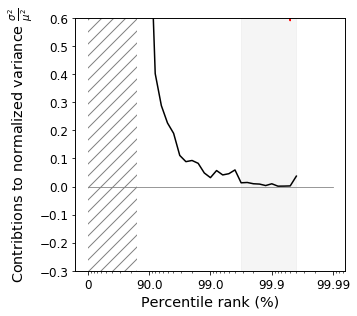

CPU times: user 629 ms, sys: 96.7 ms, total: 726 ms
Wall time: 762 ms


In [121]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_scOGS09_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_var_trvarOmega,contribQOmega_var_trvarQ,contribQOmega_var_residual],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

# leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
#                  r'$\propto Cov(q_v^{\star,2},\omega^2)$',
#                  r'$\propto Var(q_v^\star)$',
#                  r'$\propto Var(\omega)$',
#                  r'$\propto Var(q_v^\star)Var(\omega)$',
#                  r'$\propto -Cov(q_v^\star,\omega)^2$',
#                  r'$\propto -Cov(q_v^\star,\omega)$',
#                  r'sum of all'],
#                  loc='upper left',
#                  framealpha=0.8,
#                  ncol=2)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contribtions to normalized variance $\frac{\sigma^2}{\mu^2}$')

# plt.savefig(os.path.join(figdir,'var_and_contributions_omega_q_%s.pdf'%output_suffix),
#             bbox_inches='tight')

plt.show()